# Few-Shot Learning with Reptile

## Biweekly Report 6

## Jake Watts

In this report, I train a model for few-shot learning on Omniglot data using the Reptile algorithm. The Omniglot dataset consists of 1,623 unique hand-written characters from 50 different alphabets, with 20 examples per character. The reptile algorithm is a meta-learning algorithm that works by sampling a group of characters in a mini-batch, training to classify those characters, and then moving the initialized weights based on the mini-batch weights. The goal is to get a model with initialized weights than can be fine-tuned to adapt to classify new groups of characters quickly.

After training the model on Omniglot data, I also test the model's ability for few-shot learning on the MNIST dataset to see if the results are consistent across datasets.

Sources:

https://arxiv.org/abs/1803.02999

https://keras.io/examples/vision/reptile/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

Setting the hyperparameters for training. Each training batch will contain 25 images composed of 5 classes and 4 images per class. There will be 2,000 meta iterations overall and 4 steps within each iteration.

In [2]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5

## Data + Pre-Processing

The class `Dataset` will be used to load and process the omniglot data.

`extraction` converts the images in omniglot to grayscale and reiszes them to 28x28 images.

`get_mini_dataset` returns a training and testing mini-batch based on the specified shot and class hyperparameters. It also creates new labels for each of the characters in the dataset. Since we are getting 5 classes in each mini-batch, the labels in each mini-batch will range from 0 to 4.

In [3]:
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incomplete61SXXH/omniglot-train.tfrecord


  0%|          | 0/19280 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incomplete61SXXH/omniglot-test.tfrecord


  0%|          | 0/13180 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incomplete61SXXH/omniglot-small1.tfrecord


  0%|          | 0/2720 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incomplete61SXXH/omniglot-small2.tfrecord


  0%|          | 0/3120 [00:00<?, ? examples/s]

Dataset omniglot downloaded and prepared to /root/tensorflow_datasets/omniglot/3.0.0. Subsequent calls will reuse this data.


Below we can see example images from the Omniglot data. In the visualization, there are 5 examples taken from 5 classes for a total of 25 images. This set of images is similar to a mini-batch with 5 shots and 5 classes, except the labels would be 0 through 4 rather than the original labels from the data.

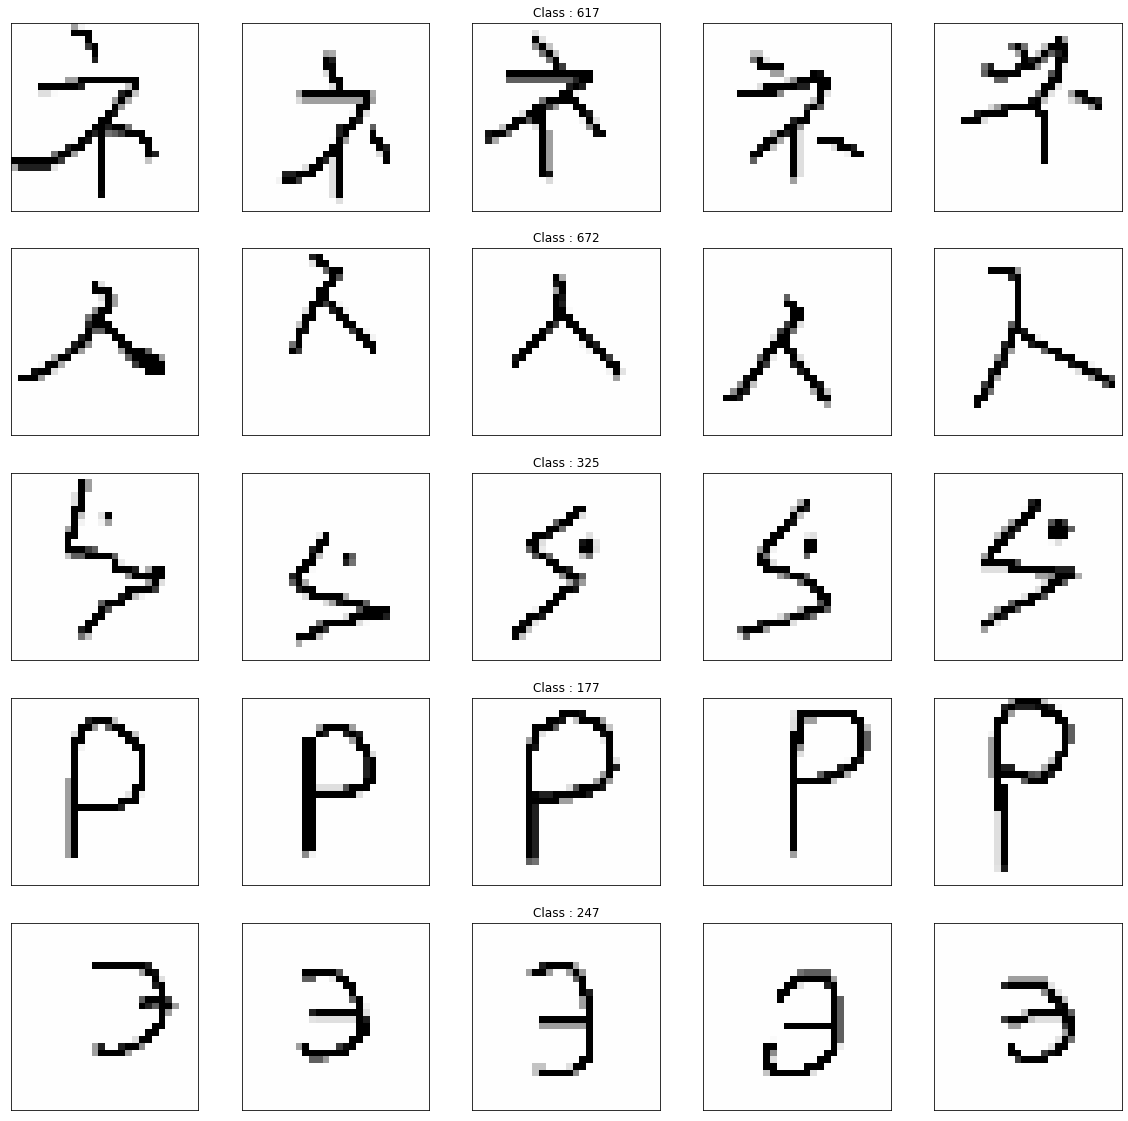

In [4]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
    for b in range(5):
        temp_image = train_dataset.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

## Model Architecture

`conv_bn` consists of a convolutional layer with 64 filters, with a kernel size of 3 and stride of 2, followed by batch normalization.

The overall model architecture is fairly simple so that it can quickly adapt to different classification tasks. It contains four convolutional layers. The output from the convolutional layers is flattened and fed into a dense layer of size 5, with softmax activation to classify the characters.

In [5]:
def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

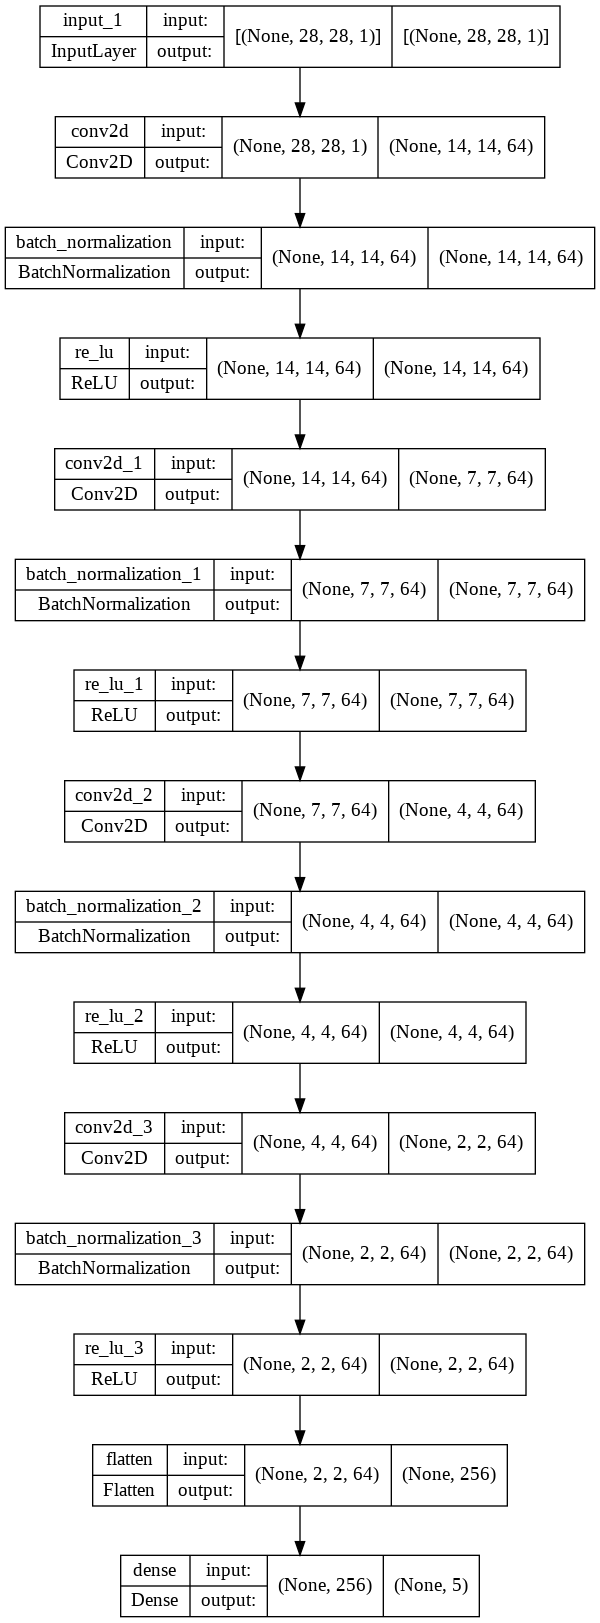

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Loss + Training

The weights for the reptile learning algorithm are calculated as a function of the old weights (`old_vars`) and the new weights (`new_vars`). The old weights are the initialized weights. The new weights are calculated with the mini-batch samples of Omniglot data using stochastic gradient descent with a learning rate of .003 and a categorical cross-entropy loss function.

The updated weights are calculated as: `old_vars` + (`old_vars` - `new_vars`) * `cur_meta_step_size` where `cur_meta_step_size` is like a learning rate that decreasing with every meta-iteration.

To get the test accuracy as we train, we use the updated weights to train a model on a mini-dataset. We predict on a test dataset containing one example for each of the five randomly chosen characters.

In [6]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )

batch 0: train=0.600000 test=0.800000
batch 100: train=1.000000 test=1.000000
batch 200: train=1.000000 test=1.000000
batch 300: train=1.000000 test=0.600000
batch 400: train=0.800000 test=1.000000
batch 500: train=0.400000 test=1.000000
batch 600: train=0.400000 test=1.000000
batch 700: train=1.000000 test=0.600000
batch 800: train=1.000000 test=1.000000
batch 900: train=1.000000 test=1.000000
batch 1000: train=1.000000 test=0.800000
batch 1100: train=0.600000 test=0.800000
batch 1200: train=1.000000 test=1.000000
batch 1300: train=1.000000 test=0.800000
batch 1400: train=1.000000 test=1.000000
batch 1500: train=0.800000 test=1.000000
batch 1600: train=1.000000 test=1.000000
batch 1700: train=1.000000 test=1.000000
batch 1800: train=1.000000 test=0.600000
batch 1900: train=0.600000 test=0.800000


After 2000 meta iterations, we can see that the model starts to accurately classify test data around 90% of the time after training on very small datasets of characters. This indicates that the initialized model weights can quickly adapt to learn new characters with a small amount of information.

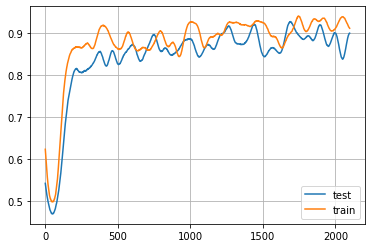

In [67]:
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

## Model Evaluation

Here is an example of few-shot learning in action. Here we create a mini-dataset containing five examples of five different characters. We start with the initialized weights found while training the model and update the weights based on the mini-dataset loss.

Then we predict on a test set with only one example of each character. We can see in the visualization below that the model classified each character correctly!

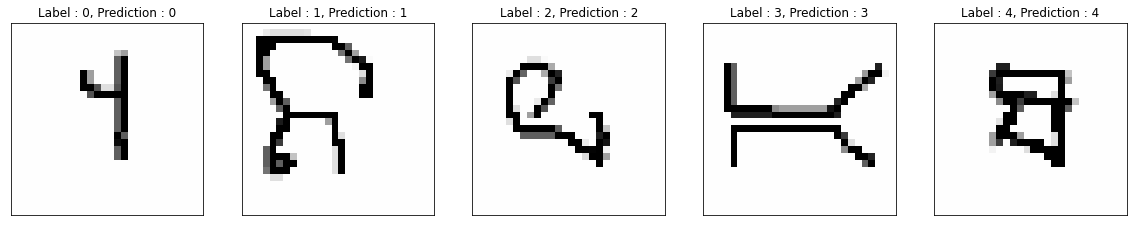

In [88]:
train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

## Testing on MNIST data

We found that the initialized weights created by training the model work well for few-shot learning on the Omniglot data. Here I wanted to test if the weights also work well for few-shot learning on the MNIST dataset. MNIST is similar to Omniglot in that it contains hand-written symbols, except MNIST contains digits while Omniglot contains characters.

Here I rewrite the code for the class `Dataset` to read in MNIST data rather than Omniglot.

In [110]:
class Dataset_mnist:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        ds = tfds.load("mnist", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            image = tf.image.convert_image_dtype(image, tf.float32)
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset

In [112]:
urllib3.disable_warnings() 
mnist_train = Dataset_mnist(training=True)

Here we see some of the MNIST data visualized. There are a few key differences between the MNIST and Omniglot data. First, the MNIST data has a black background with white digits, while the Omniglot data has a white background with black characters.

Second, the digits in MNIST appear to be a bit thicker than the characters in Omniglot. Similar to the difference between writing with a pencil and a sharpie.

Third, the MNIST data has fewer classes which means it would not be suitable for training a few-shot learning model but should be sufficient for testing the model.

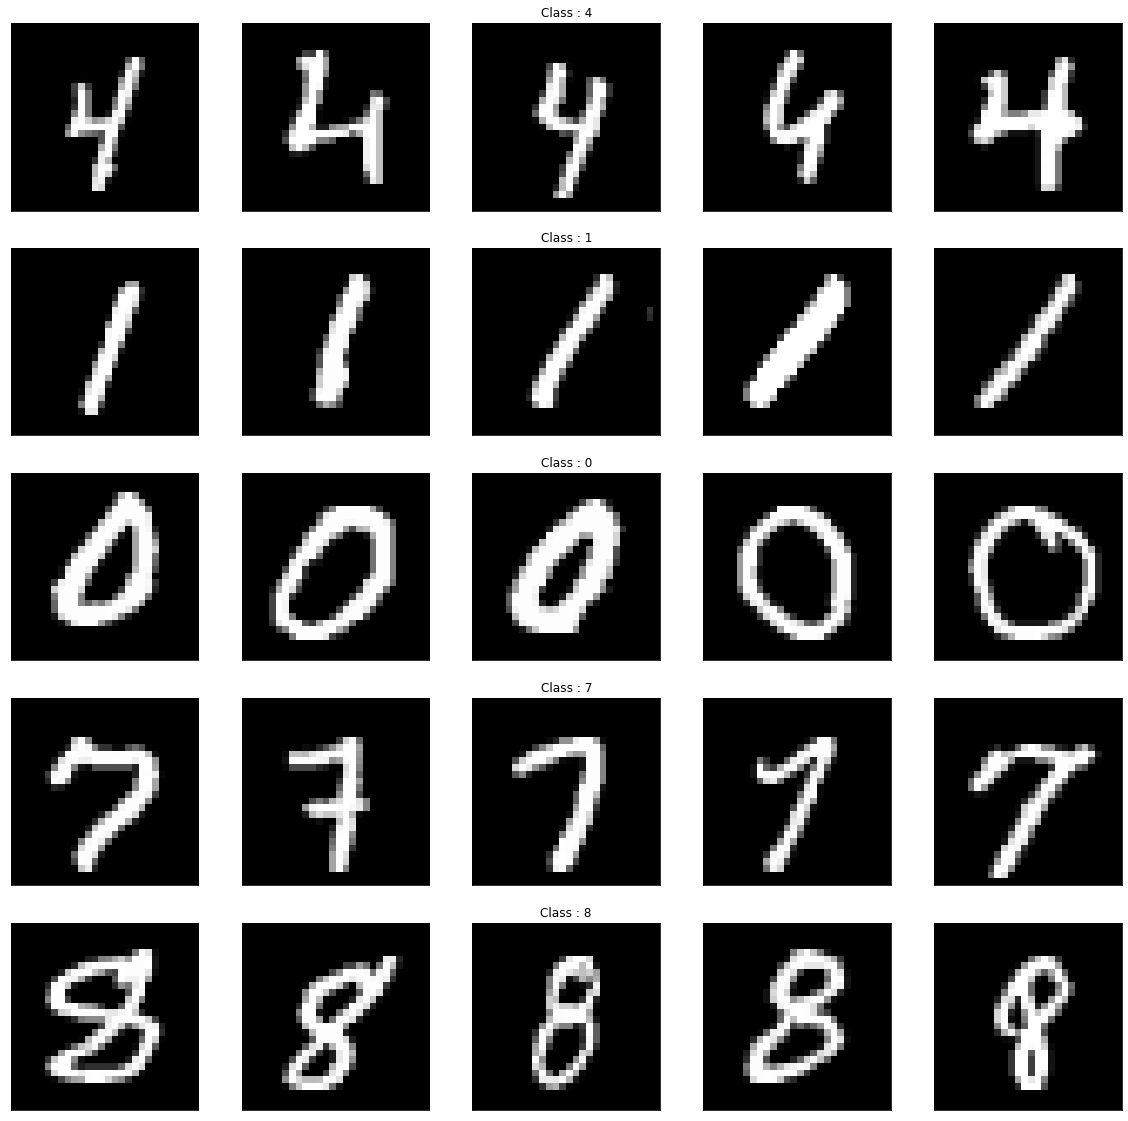

In [113]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(mnist_train.data.keys())

for a in range(5):
    for b in range(5):
        temp_image = mnist_train.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

Below is the output for a prediction on five test images after briefing training on a small dataset by updating the initialized parameters. We can see that the model only gets two correct labels. It is also worth noting that the labels do not match the numbers because all labels are reassigned to values from 0 to 4 when the classes are randomly selected.

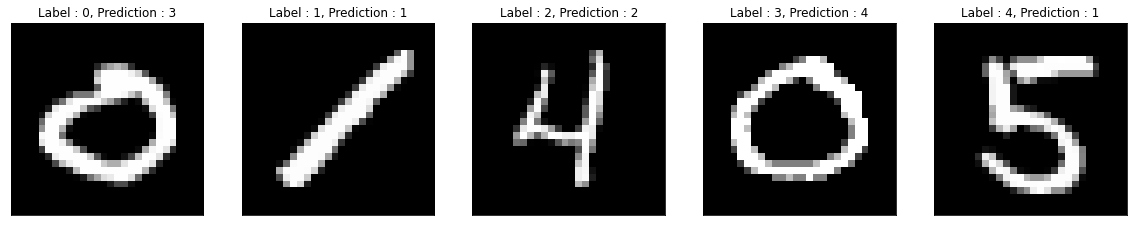

In [118]:
train_set, test_images, test_labels = mnist_train.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

Since 5 predictions is a small sample size, the following code creates predictions on small training and test sets created from MNIST data 100 times to see how well the few shot model performs on MNIST data overall.

In [164]:
test_acc_ = []

for i in range(100):
  # Sample a mini dataset from the full dataset.
  train_set, test_images, test_labels = mnist_train.get_mini_dataset(
  eval_batch_size, eval_iters, shots, classes, split=True
  )
  old_vars = model.get_weights()
  # Train on the samples and get the resulting accuracies.
  for images, labels in train_set:
    with tf.GradientTape() as tape:
      preds = model(images)
      loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
  test_preds = model.predict(test_images)
  test_preds = tf.argmax(test_preds).numpy()
  num_correct = (test_preds == test_labels).sum()
    # Reset the weights after getting the evaluation accuracies.
  model.set_weights(old_vars)
  acc = num_correct / classes
  test_acc_.append(acc)

The average accuracy is 0.58, which is better than the expected value from random guessing (0.20) but worse than the testing values we got on the Omniglot dataset, which fluctuated around .90 towards the end of the meta iterations.

In [165]:
np.mean(test_acc_).round(2)

0.58

## Reversing MNIST Colors


Maybe the weights will initial weights generalize better if we change the background from black to white to match the background of Omniglot. Here I update the function to reverse the colors.

In [148]:
class Dataset_mnist2:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        ds = tfds.load("mnist", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}

        def extraction(image, label):
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = 1 - image
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset

In [149]:
mnist_train2 = Dataset_mnist2(training=True)

Now the color of the background and symbols match the Omniglot data.

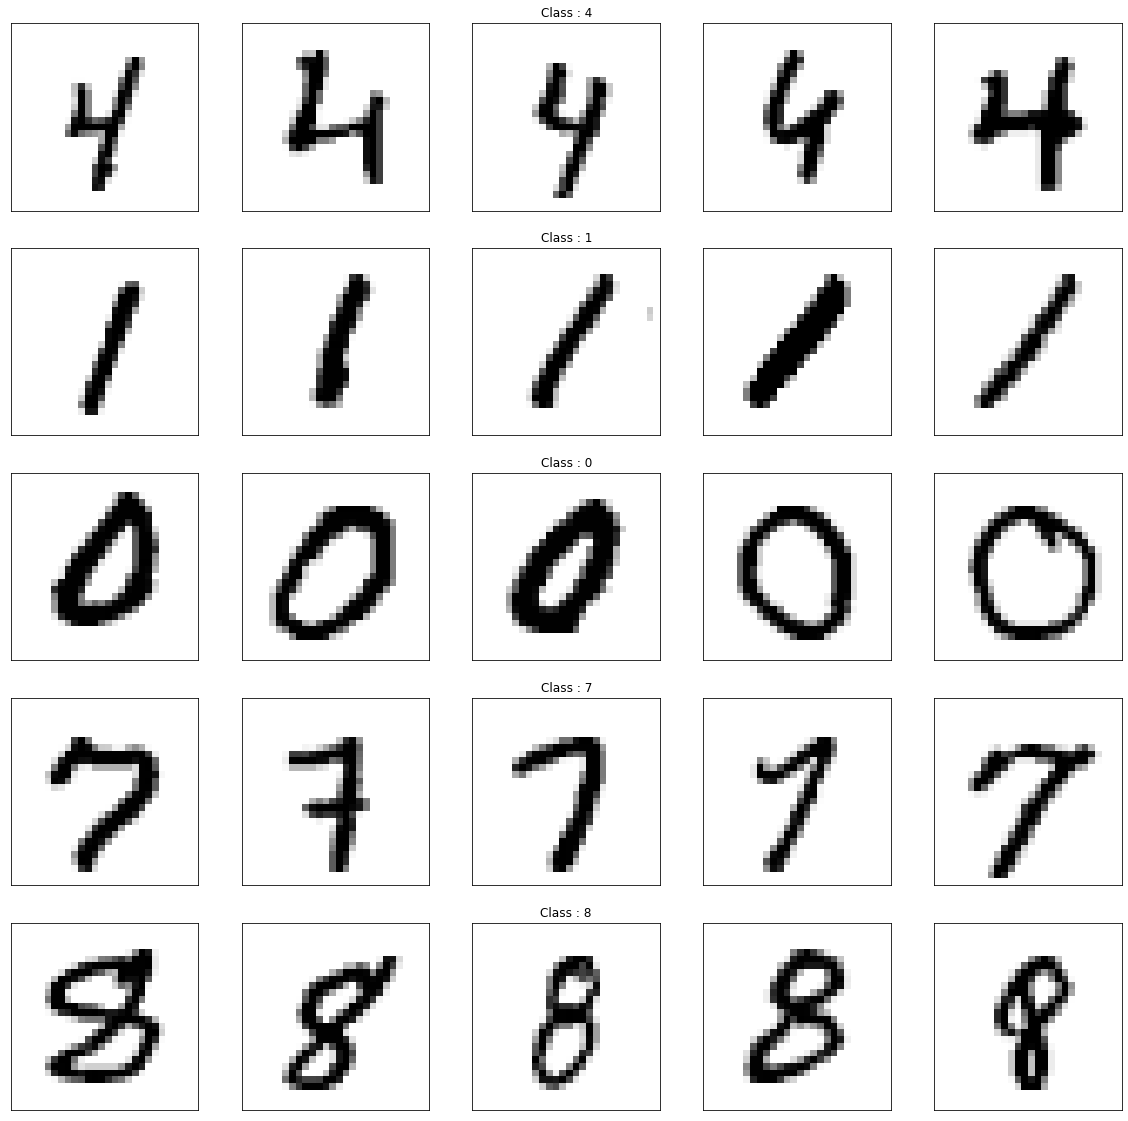

In [151]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(mnist_train2.data.keys())

for a in range(5):
    for b in range(5):
        temp_image = mnist_train2.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

Training 100 models, starting with the initialized weights of the trained models and testing on sets of size 5

In [160]:
test_acc = []

for i in range(100):
  # Sample a mini dataset from the full dataset.
  train_set, test_images, test_labels = mnist_train2.get_mini_dataset(
  eval_batch_size, eval_iters, shots, classes, split=True
  )
  old_vars = model.get_weights()
  # Train on the samples and get the resulting accuracies.
  for images, labels in train_set:
    with tf.GradientTape() as tape:
      preds = model(images)
      loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
  test_preds = model.predict(test_images)
  test_preds = tf.argmax(test_preds).numpy()
  num_correct = (test_preds == test_labels).sum()
    # Reset the weights after getting the evaluation accuracies.
  model.set_weights(old_vars)
  acc = num_correct / classes
  test_acc.append(acc)

Changing the colors results in an increase in accuracy from 0.58 to 0.74, demonstrating that the more similar the data is to the Omniglot data, the better our initialized weights will work for few-shot learning.

In [162]:
np.mean(test_acc).round(2)

0.74

## Summary

Few-shot learning appears to be a very useful tool for training a model when there is only a small amount of data available. Few-shot learning is similar to how humans learn in that there only needs to be a few examples to start picking up on the pattern. However, this algorithm is still not as accurate as human performance.

It seems that this model works well when trained to classify new characters from the Omniglot dataset, but performance significantly drops when trying to do few-shot learning with the same initialized weights on a different dataset. Things like that background color would likely not affect a human's ability to learn but seem to significantly affect the model's ability to learn.

Even adjusting for the background color, the performance on the MNIST dataset is still not as good as the performance using characters from Omniglot. This suggests that the model might be overfitting to other aspects of the dataset, such as the thickness of the written symbols. This difference in performance should be taken into account when using few-shot learning in a real-world setting.